In [2]:
import os 
import numpy as np
import re

## plotting ###

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [1]:
PATH = './models/parameter_search/'

In [6]:
root, _, files = list(os.walk(PATH))[0]
npy_files = [f for f in files if f.split('.')[-1] == 'npy']
npy_files.sort()

In [7]:
len(npy_files)/3

48.0

In [170]:
### run this code to create the parameter file

#embedding_dims = [16,32]
#latent_dims = [8,16,32]
#dropout = [.1,.3,.5]
#pooling = ['avg', 'max']
#parameter_grid = list(product(embedding_dims, latent_dims, dropout, pooling))

#for npy_file in npy_files:
#    numbers = re.findall(r'[\d\.]+',npy_file)
#    t = (int(numbers[0]), int(numbers[2]), float(numbers[3]), npy_file[-9:-6])
#    if numbers[5] == '3.':
#        parameter_grid.remove(t)
#with open('./models/parameter_search/parameter_grid.txt', 'wb') as f: 
#    np.save(f, np.array(parameter_grid))

In [8]:
# Combine the runs and take the average
loss_dict= {}
for npy_file in npy_files:
    
    with open(PATH+npy_file, 'rb') as f:
        losses = np.load(f)
        
        key = npy_file[:-6]
        if key not in loss_dict.keys():
            loss_dict[key] = losses
        else:
            loss_dict[key] = np.hstack((loss_dict[key], losses))
        

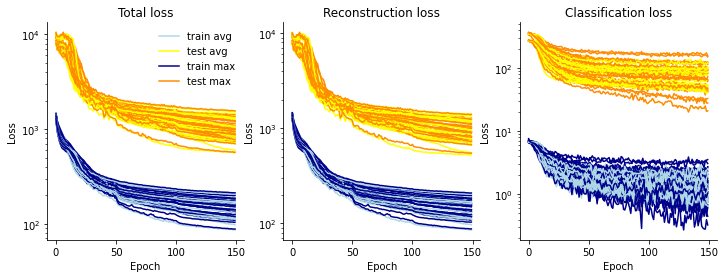

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12,4))
axes = axes.flatten()

titles = ['Total loss', 'Reconstruction loss', 'Classification loss']
for key, item in loss_dict.items():
    
    if key.find('max') > -1:
        c_train = 'darkblue'
        c_val = 'darkorange'
    else:
        c_train = 'lightblue'
        c_val = 'yellow'
        
    #plot mean total training loss
    axes[0].plot(item[:, 0::4].mean(axis=1), c=c_train, label='train')
    # plot mean total validation loss
    axes[0].plot(item[:, 2::4].mean(axis=1), c=c_val, label='validation')
        
    #plot mean reconstruction training loss
    axes[1].plot(item[:, 0::4].mean(axis=1) - item[:, 1::4].mean(axis=1), c=c_train, label='train')
    # plot mean reconstruction validation loss
    axes[1].plot(item[:, 2::4].mean(axis=1) - item[:, 3::4].mean(axis=1), c=c_val, label='validation')
    
    #plot mean classification training loss
    axes[2].plot(item[:, 1::4].mean(axis=1), c=c_train, label='train')
    # plot mean total validation loss
    axes[2].plot(item[:, 3::4].mean(axis=1), c=c_val, label='validation')
    
for k, ax in enumerate(axes): 
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    ax.set_title(titles[k])
sns.despine()
legend_handles, _ = axes[0].get_legend_handles_labels()
axes[0].legend(legend_handles[:4], ['train avg', 'test avg', 'train max', 'test max'], frameon=False)

In [11]:
best_val_loss = np.infty
best_model = ''

for key, item in loss_dict.items():
    
    min_val_loss = np.min(item[:, 2::4].mean(axis=1))
    if min_val_loss < best_val_loss:
        best_val_loss = min_val_loss
        best_model = key
print('Model %s has the best validation loss of '%best_model, np.round(best_val_loss, 4))

Model losses_emb32_hid32_lat32_dp0.1_k500_avg has the best validation loss of  565.3392


In [13]:
import re
import pandas as pd

In [14]:
min_loss_dict = {'emb': [], 'hid': [], 'lat': [], 'dropout': [], 'kappa': [], 'pool': [], 
                'min_loss': [], 'loss_std': []}
for key, item in loss_dict.items():
    
    mean_val_loss = item[:, 2::4].mean(axis=1)
    min_ix = np.argmin(mean_val_loss)
    min_val_loss = mean_val_loss[min_ix]
    
    std_val_loss = item[:, 2::4].std(axis=1)
    
    numbers = re.findall(r'\d+', key) 
    min_loss_dict['emb'] += [int(numbers[0])]
    min_loss_dict['hid'] += [int(numbers[1])]
    min_loss_dict['lat'] += [int(numbers[2])]
    min_loss_dict['dropout'] += [float('.'.join(numbers[3:5]))]
    min_loss_dict['kappa'] += [int(numbers[5])]
    min_loss_dict['pool'] += [key[-3:]]
    
    min_loss_dict['min_loss'] += [min_val_loss]
    min_loss_dict['loss_std'] += [std_val_loss[min_ix]]
df = pd.DataFrame(min_loss_dict)

In [19]:
df.groupby(['emb', 'hid', 'lat', 'dropout', 'kappa', 'pool']).mean()


min_loss    loss_std
emb hid lat dropout kappa pool                         
16  16  8   0.1     100   avg   1069.151750  117.918713
                          max   1057.024667  101.497975
                    500   avg    983.070542   38.182593
                          max    988.880479   59.738599
            0.3     100   avg   1297.129661   81.712663
                          max   1357.274740   44.686408
            0.5     100   avg   1526.704479   70.051699
                          max   1558.516458   85.502686
        16  0.1     100   avg    906.827042   90.971119
                          max    944.382167   52.364028
                    500   avg    820.603187  102.331071
                          max    793.198104   45.603098
            0.3     100   avg   1255.147760  121.158307
                          max   1222.144115   29.543802
            0.5     100   avg   1458.162969  101.638324
                          max   1406.287448    6.132478
        32  0.1     100   avg    866.210333   18.847765
                          max    940.346479   73.075956
                    500   avg    716.203000   64.127450
                          max    741.872896  104.669537
            0.3     100   avg   1090.068021   52.671574
                          max   1094.489323   82.088479
            0.5     100   avg   1369.414844   10.007715
                          max   1346.169036   53.299719
32  32  8   0.1     100   avg    841.559083   43.872529
                          max    886.807688  117.016226
                    500   avg    789.151167   25.074916
                          max    773.202833   77.819688
            0.3     100   avg   1058.814661  103.644840
                          max   1149.437813  114.272724
            0.5     100   avg   1313.851510   69.180607
                          max   1201.058073   81.408443
        16  0.1     100   avg    716.774167   31.473363
                          max    775.167958   61.719253
                    500   avg    598.859604   16.607461
                          max    698.444771   81.902439
            0.3     100   avg    897.100859   43.651715
                          max    999.450000   69.506769
            0.5     100   avg   1247.020234   14.245209
                          max   1224.824661   20.024049
        32  0.1     100   avg    758.140937   24.447860
                          max    843.984427   21.384753
                    500   avg    565.339167    7.958706
                          max    565.647875    1.394318
            0.3     100   avg    899.530182    5.200627
                          max    870.795625   28.452493
            0.5     100   avg   1022.272917   50.069118
                          max   1004.630938   14.404794

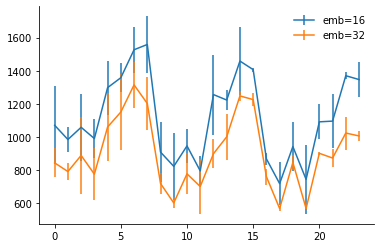

In [18]:
emb16_df = df[df['emb'] == 16].sort_values(['lat', 'dropout', 'pool'])
emb32_df = df[df['emb'] == 32].sort_values(['lat', 'dropout', 'pool'])
plt.errorbar(x=range(24), y=emb16_df['min_loss'], yerr=2*emb16_df['loss_std'], label='emb=16')
plt.errorbar(x=range(24), y=emb32_df['min_loss'], yerr=2*emb32_df['loss_std'], label='emb=32')
sns.despine()
plt.legend(frameon=False)

In [13]:
sns.set(font_scale=1.3)
sns.set_style('ticks')

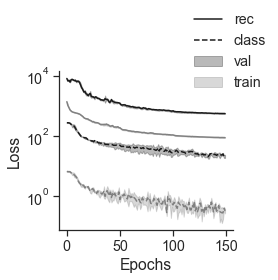

In [17]:
plt.figure(figsize=(4,4))
best_run_max = loss_dict['losses_emb32_hid32_lat32_dp0.1_k500_max']

rec_loss = best_run_max[:,0::2] - best_run_max[:,1::2] 

plt.plot(rec_loss[:,1::2].mean(axis=1), c='k', label='rec')
plt.fill_between(range(150), 
                 rec_loss[:,1::2].mean(axis=1) - rec_loss[:,1::2].std(axis=1), 
                 rec_loss[:,1::2].mean(axis=1) + rec_loss[:,1::2].std(axis=1), 
                alpha=.3, color='k')

plt.plot(best_run_max[:,3::4].mean(axis=1), '--', c='k', label='class')
plt.fill_between(range(150), 
                 best_run_max[:,3::4].mean(axis=1) - best_run_max[:,3::4].std(axis=1), 
                 best_run_max[:,3::4].mean(axis=1) + best_run_max[:,3::4].std(axis=1), 
                alpha=.3, color='k', label='val')


plt.plot(rec_loss[:,0::2].mean(axis=1), c='grey')
plt.fill_between(range(150), 
                 rec_loss[:,0::2].mean(axis=1) - rec_loss[:,0::2].std(axis=1), 
                 rec_loss[:,0::2].mean(axis=1) + rec_loss[:,0::2].std(axis=1), 
                alpha=.3, color='grey', label='train')


plt.plot(best_run_max[:,1::4].mean(axis=1), '--', c='grey')
plt.fill_between(range(150), 
                 best_run_max[:,1::4].mean(axis=1) - best_run_max[:,1::4].std(axis=1), 
                 best_run_max[:,1::4].mean(axis=1) + best_run_max[:,1::4].std(axis=1), 
                alpha=.3, color='grey')


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.gca().set_yscale('log')
sns.despine()
plt.legend(frameon=False, bbox_to_anchor=(.7,.8))
plt.tight_layout()
plt.savefig('./pics/ICML/v5/Fig3/best_model_losses.svg', format='svg')

In [20]:
with open('./models/classification_analysis/amountOfLabels.txt', 'rb') as f:
    l = np.load(f)
l

array([0.4 , 0.3 , 0.2 , 0.15, 0.1 , 0.05, 0.  ])

In [24]:
l = np.array([1.,0.9, 0.8 ,.7, .6,.5, 0.4 , 0.3 , 0.2 , 0.15, 0.1 , 0.05, 0.])
with open('./models/classification_analysis/amountOfLabels.txt', 'wb') as f:
    np.save(f, l)